In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# 读取数据集
def load_dataset(root_folder):
    images = []
    labels = []

    for folder_name, label in {'bulbasaur': 0, 'charmander': 1, 'mewtwo': 2, 'pikachu': 3, 'squirtle': 4}.items():
        folder_path = os.path.join(root_folder, folder_name)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (64, 64))  # 调整图像大小
            images.append(img.flatten())  # 将图像展平
            labels.append(label)

    return np.array(images), np.array(labels)

# 加载数据集
root_folder = "/kaggle/input/deep-learning-bnuz-2023-fall-final-work/deeplearning/pokeman"
images, labels = load_dataset(root_folder)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# 构建并训练随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = rf_model.predict(X_test)

# 计算准确度
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



# 构建并训练决策树模型
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_dt = dt_model.predict(X_test)

# 计算准确度
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: kno

Accuracy: 0.8376068376068376
Decision Tree Accuracy: 0.6780626780626781


In [2]:
from typing import Callable, List, Optional

import torch
from torch import nn, Tensor
from torch.nn import functional as F
from functools import partial


def _make_divisible(ch, divisor=8, min_ch=None):
    if min_ch is None:
        min_ch = divisor
    new_ch = max(min_ch, int(ch + divisor / 2) // divisor * divisor)
    # 确保向下舍入不超过原值的10%。
    if new_ch < 0.9 * ch:
        new_ch += divisor
    return new_ch


class ConvBNActivation(nn.Sequential):
    def __init__(self,
                 in_planes: int,
                 out_planes: int,
                 kernel_size: int = 3,
                 stride: int = 1,
                 groups: int = 1,
                 norm_layer: Optional[Callable[..., nn.Module]] = None,
                 activation_layer: Optional[Callable[..., nn.Module]] = None):
        padding = (kernel_size - 1) // 2
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if activation_layer is None:
            activation_layer = nn.ReLU6
        super(ConvBNActivation, self).__init__(nn.Conv2d(in_channels=in_planes,
                                                         out_channels=out_planes,
                                                         kernel_size=kernel_size,
                                                         stride=stride,
                                                         padding=padding,
                                                         groups=groups,
                                                         bias=False),
                                               norm_layer(out_planes),
                                               activation_layer(inplace=True))


class SqueezeExcitation(nn.Module):
    def __init__(self, input_c: int, squeeze_factor: int = 4):
        super(SqueezeExcitation, self).__init__()
        squeeze_c = _make_divisible(input_c // squeeze_factor, 8)
        self.fc1 = nn.Conv2d(input_c, squeeze_c, 1)
        self.fc2 = nn.Conv2d(squeeze_c, input_c, 1)

    def forward(self, x: Tensor) -> Tensor:
        scale = F.adaptive_avg_pool2d(x, output_size=(1, 1))
        scale = self.fc1(scale)
        scale = F.relu(scale, inplace=True)
        scale = self.fc2(scale)
        scale = F.hardsigmoid(scale, inplace=True)
        return scale * x


class InvertedResidualConfig:
    def __init__(self,
                 input_c: int,
                 kernel: int,
                 expanded_c: int,
                 out_c: int,
                 use_se: bool,
                 activation: str,
                 stride: int,
                 width_multi: float):
        self.input_c = self.adjust_channels(input_c, width_multi)
        self.kernel = kernel
        self.expanded_c = self.adjust_channels(expanded_c, width_multi)
        self.out_c = self.adjust_channels(out_c, width_multi)
        self.use_se = use_se
        self.use_hs = activation == "HS"  # 是否使用 h-swish 激活函数
        self.stride = stride

    @staticmethod
    def adjust_channels(channels: int, width_multi: float):
        return _make_divisible(channels * width_multi, 8)


class InvertedResidual(nn.Module):
    def __init__(self,
                 cnf: InvertedResidualConfig,
                 norm_layer: Callable[..., nn.Module]):
        super(InvertedResidual, self).__init__()

        if cnf.stride not in [1, 2]:
            raise ValueError("非法的步幅值.")

        self.use_res_connect = (cnf.stride == 1 and cnf.input_c == cnf.out_c)

        layers: List[nn.Module] = []
        activation_layer = nn.Hardswish if cnf.use_hs else nn.ReLU

        # 扩张
        if cnf.expanded_c != cnf.input_c:
            layers.append(ConvBNActivation(cnf.input_c,
                                           cnf.expanded_c,
                                           kernel_size=1,
                                           norm_layer=norm_layer,
                                           activation_layer=activation_layer))

        # 深度卷积
        layers.append(ConvBNActivation(cnf.expanded_c,
                                       cnf.expanded_c,
                                       kernel_size=cnf.kernel,
                                       stride=cnf.stride,
                                       groups=cnf.expanded_c,
                                       norm_layer=norm_layer,
                                       activation_layer=activation_layer))

        if cnf.use_se:
            layers.append(SqueezeExcitation(cnf.expanded_c))

        # 投影
        layers.append(ConvBNActivation(cnf.expanded_c,
                                       cnf.out_c,
                                       kernel_size=1,
                                       norm_layer=norm_layer,
                                       activation_layer=nn.Identity))

        self.block = nn.Sequential(*layers)
        self.out_channels = cnf.out_c
        self.is_strided = cnf.stride > 1

    def forward(self, x: Tensor) -> Tensor:
        result = self.block(x)
        if self.use_res_connect:
            result += x

        return result


class MobileNetV3(nn.Module):
    def __init__(self,
                 inverted_residual_setting: List[InvertedResidualConfig],
                 last_channel: int,
                 num_classes: int = 1000,
                 block: Optional[Callable[..., nn.Module]] = None,
                 norm_layer: Optional[Callable[..., nn.Module]] = None):
        super(MobileNetV3, self).__init__()

        if not inverted_residual_setting:
            raise ValueError("倒置残差设置不应为空.")
        elif not (isinstance(inverted_residual_setting, List) and
                  all([isinstance(s, InvertedResidualConfig) for s in inverted_residual_setting])):
            raise TypeError("倒置残差设置应为 List[InvertedResidualConfig]")

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = partial(nn.BatchNorm2d, eps=0.001, momentum=0.01)

        layers: List[nn.Module] = []

        # 构建第一层
        firstconv_output_c = inverted_residual_setting[0].input_c
        layers.append(ConvBNActivation(3,
                                       firstconv_output_c,
                                       kernel_size=3,
                                       stride=2,
                                       norm_layer=norm_layer,
                                       activation_layer=nn.Hardswish))
        # 构建倒置残差块
        for cnf in inverted_residual_setting:
            layers.append(block(cnf, norm_layer))

        # 构建最后几层
        lastconv_input_c = inverted_residual_setting[-1].out_c
        lastconv_output_c = 6 * lastconv_input_c
        layers.append(ConvBNActivation(lastconv_input_c,
                                       lastconv_output_c,
                                       kernel_size=1,
                                       norm_layer=norm_layer,
                                       activation_layer=nn.Hardswish))
        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(nn.Linear(lastconv_output_c, last_channel),
                                        nn.Hardswish(inplace=True),
                                        nn.Dropout(p=0.2, inplace=True),
                                        nn.Linear(last_channel, num_classes))

        # 初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def mobilenet_v3_large(num_classes: int = 1000,
                       reduced_tail: bool = False) -> MobileNetV3:
    width_multi = 1.0
    bneck_conf = partial(InvertedResidualConfig, width_multi=width_multi)
    adjust_channels = partial(InvertedResidualConfig.adjust_channels, width_multi=width_multi)

    reduce_divider = 2 if reduced_tail else 1

    inverted_residual_setting = [
        # input_c, kernel, expanded_c, out_c, use_se, activation, stride
        bneck_conf(16, 3, 16, 16, False, "RE", 1),
        bneck_conf(16, 3, 64, 24, False, "RE", 2),  # C1
        bneck_conf(24, 3, 72, 24, False, "RE", 1),
        bneck_conf(24, 5, 72, 40, True, "RE", 2),  # C2
        bneck_conf(40, 5, 120, 40, True, "RE", 1),
        bneck_conf(40, 5, 120, 40, True, "RE", 1),
        bneck_conf(40, 3, 240, 80, False, "HS", 2),  # C3
        bneck_conf(80, 3, 200, 80, False, "HS", 1),
        bneck_conf(80, 3, 184, 80, False, "HS", 1),
        bneck_conf(80, 3, 184, 80, False, "HS", 1),
        bneck_conf(80, 3, 480, 112, True, "HS", 1),
        bneck_conf(112, 3, 672, 112, True, "HS", 1),
        bneck_conf(112, 5, 672, 160 // reduce_divider, True, "HS", 2),  # C4
        bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1),
        bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1),
    ]
    last_channel = adjust_channels(1280 // reduce_divider)  # C5

    return MobileNetV3(inverted_residual_setting=inverted_residual_setting,
                       last_channel=last_channel,
                       num_classes=num_classes)


成功添加类别和图像名称
使用 cpu 设备.
{'bulbasaur': 0, 'charmander': 1, 'mewtwo': 2, 'pikachu': 3, 'squirtle': 4}
Using 4 dataloader workers every process
using 780 images for training, 387 images for validation.
train epoch[1/25]: 100%|██████████| 49/49 [00:12<00:00,  3.89it/s]
[epoch 1] train_loss: 1.067  val_accuracy: 0.879 train_accuracy: 0.944
train epoch[2/25]: 100%|██████████| 49/49 [00:12<00:00,  3.98it/s]
[epoch 2] train_loss: 0.259  val_accuracy: 0.902 train_accuracy: 0.972
train epoch[3/25]: 100%|██████████| 49/49 [00:12<00:00,  3.98it/s]
[epoch 3] train_loss: 0.144  val_accuracy: 0.915 train_accuracy: 0.986
train epoch[4/25]: 100%|██████████| 49/49 [00:12<00:00,  3.94it/s]
[epoch 4] train_loss: 0.112  val_accuracy: 0.910 train_accuracy: 0.983
train epoch[5/25]: 100%|██████████| 49/49 [00:12<00:00,  3.78it/s]
[epoch 5] train_loss: 0.132  val_accuracy: 0.912 train_accuracy: 0.985
train epoch[6/25]: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s]
[epoch 6] train_loss: 0.071  val_accuracy: 0.

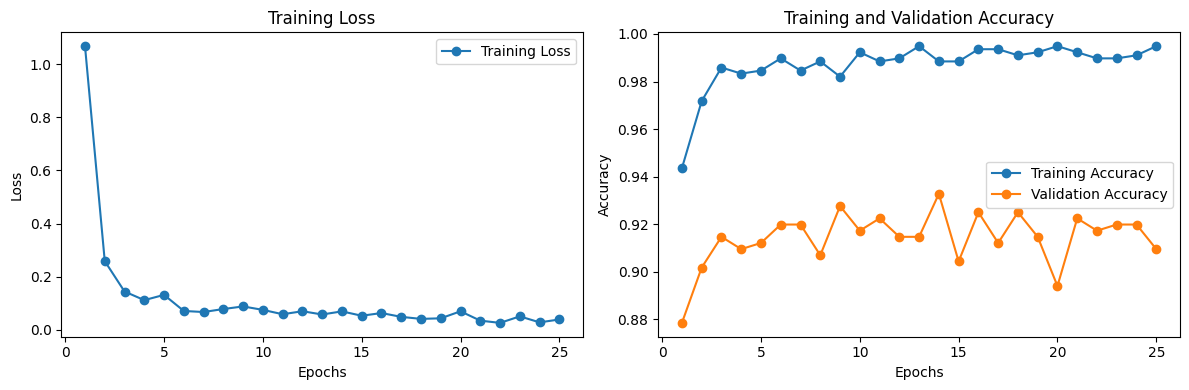

In [3]:
import os
import sys
import json
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import shutil
import warnings

# 禁用所有警告
warnings.filterwarnings("ignore")

def main():
    # 读取数据
    data = pd.read_excel('/kaggle/input/deep-learning-bnuz-2023-fall-final-work/images1.xlsx')
    data['class'] = 'a'
    for i in range(len(data)):
        a = data['path'][i].find('pokeman') + 8
        b = data['path'][i].find("0000") - 1 
        data['class'][i] = data['path'][i][a:b]
        data['number'][i] = data['path'][i][b:]
    print("成功添加类别和图像名称")
    class_set = set(data['class'])
    # 根据 "dataset" 列划分训练集和测试集
    train_data = data[data['dataset'] == 0]
    test_data = data[data['dataset'] == 1]
    # 进行transform
    data_transform = {
        "train": transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    # 定义数据集路径 kaggle 读取方式和正常本地读取方式有所不同，有一个数据集只能读 有一个可以用来work
    image_path_read = '/kaggle/input/deep-learning-bnuz-2023-fall-final-work/deeplearning/'  # 替换成实际的图片数据集路径
    # 定义数据集路径
    image_path = '/kaggle/working/pokeman/'  # 替换成实际的图片数据集路径
    batch_size = 16
    epochs = 25
    # 创建训练集和测试集文件夹
    os.makedirs(os.path.join(image_path, "train"), exist_ok=True)
    for i in class_set:
        image_path_train = image_path + "train/"
        os.makedirs(os.path.join(image_path_train, i), exist_ok=True)
    os.makedirs(os.path.join(image_path, "test"), exist_ok=True)
    for i in class_set:
        image_path_test = image_path + "test/"
        os.makedirs(os.path.join(image_path_test, i), exist_ok=True)

    # 将训练集和测试集的图片复制到对应文件夹
    for index, row in train_data.iterrows():
        src_path = image_path_read + row['path']
        src_path = src_path.replace("\\", "/")
        dst_path = os.path.join(image_path_train + row['class'], row['number'])
        shutil.copy(src_path, dst_path)

    for index, row in test_data.iterrows():
        src_path = image_path_read + row['path']
        src_path = src_path.replace("\\", "/")
        dst_path = os.path.join(image_path_test + row['class'], row['number'])
        shutil.copy(src_path, dst_path)

    # 加载训练集和测试集的数据
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path + "/train"),
                                         transform=data_transform["train"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path + "/test"),
                                        transform=data_transform["val"])

    # 创建数据加载器
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用 {} 设备.".format(device))
    train_num = len(train_dataset)
    
    """    
    # 具体类别对应的数值
    # {'bulbasaur':0, 'charmander':1, 'mewtwo':2, 'pikachu':3, 'squirtle':4}
    """
    class_list = train_dataset.class_to_idx
    print(class_list)
    cla_dict = dict((val, key) for key, val in class_list.items())
    # 将字典写入 JSON 文件
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # 工作进程数
    print('Using {} dataloader workers every process'.format(nw))
#     train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
#                                          transform=data_transform["train"])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=nw)

    val_num = len(test_dataset)

    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))

    train_loss_list = []
    train_acc_list = []
    val_acc_list = []
    
    # 创建模型
    net =  mobilenet_v3_large(num_classes=5)

    # 加载预训练权重
    # 下载链接: https://download.pytorch.org/models/mobilenet_v2-b0353104.pth
    model_weight_path = "/kaggle/input/deep-learning-bnuz-2023-fall-final-work/mobilenet_v3_large-8738ca79.pth"
    assert os.path.exists(model_weight_path), "文件 {} 不存在.".format(model_weight_path)
    pre_weights = torch.load(model_weight_path, map_location='cpu')

    # 删除分类器权重
    pre_dict = {k: v for k, v in pre_weights.items() if net.state_dict()[k].numel() == v.numel()}
    missing_keys, unexpected_keys = net.load_state_dict(pre_dict, strict=False)

    # 冻结特征权重 —— 如果不预训练则将这部分注释掉，如果要使用预训练模型，则保留这部分参数更新
#     for param in net.features.parameters():
#         param.requires_grad = False

    net.to(device)

    # 定义损失函数
    loss_function = nn.CrossEntropyLoss()

    # 构建优化器
    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=0.0001)

    best_acc = 0.0
    save_path = './MobileNetV3_train.pth'
    train_steps = len(train_loader)
    for epoch in range(epochs):
        # 训练
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            logits = net(images.to(device))
            loss = loss_function(logits, labels.to(device))
            loss.backward()
            optimizer.step()

            # 打印统计信息
            running_loss += loss.item()

            train_bar.desc = "训练 第[{}/{}] 损失:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # 验证
        net.eval()
        
        acc = 0.0
        train_acc = 0.0 # accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm(test_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                # loss = loss_function(outputs, test_labels)
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,epochs)
            train_bar = tqdm(train_loader, file=sys.stdout)
            for train_data in train_bar:
                train_images, train_labels = train_data
                outputs = net(train_images.to(device))
                # loss = loss_function(outputs, test_labels)
                predict_y = torch.max(outputs, dim=1)[1]
                train_acc += torch.eq(predict_y, train_labels.to(device)).sum().item()

                train_bar.desc = "train epoch[{}/{}]".format(epoch + 1, epochs)
                
        val_accurate = acc / val_num
        train_accurate = train_acc / train_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f train_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate,train_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
        # 记录训练过程中的损失和准确率
        train_loss_list.append(running_loss / train_steps)
        train_acc_list.append(train_accurate)
        val_acc_list.append(val_accurate)

    print('训练完成')
    print(best_acc)
    
    # 可视化训练过程
    plt.figure(figsize=(12, 4))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_loss_list, label='Training Loss', marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_acc_list, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig("result of train.png")
    plt.show()

if __name__ == '__main__':
    main()


## 下面是Transformer的实现——MobileViT

In [4]:
"""
original code from apple:
https://github.com/apple/ml-cvnets/blob/main/cvnets/models/classification/mobilevit.py
"""
# 具体实现上 参考了这篇论文的具体实现：MobileViT: Light-weight, General-purpose, and Mobile-friendly Vision Transformer, ICLR'22

from typing import Optional, Tuple, Union, Dict
import math
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F

def get_config(mode: str = "xxs") -> dict:
    if mode == "xx_small":
        mv2_exp_mult = 2
        config = {
            "layer1": {
                "out_channels": 16,
                "expand_ratio": mv2_exp_mult,
                "num_blocks": 1,
                "stride": 1,
                "block_type": "mv2",
            },
            "layer2": {
                "out_channels": 24,
                "expand_ratio": mv2_exp_mult,
                "num_blocks": 3,
                "stride": 2,
                "block_type": "mv2",
            },
            "layer3": {  # 28x28
                "out_channels": 48,
                "transformer_channels": 64,
                "ffn_dim": 128,
                "transformer_blocks": 2,
                "patch_h": 2,  # 8,
                "patch_w": 2,  # 8,
                "stride": 2,
                "mv_expand_ratio": mv2_exp_mult,
                "num_heads": 4,
                "block_type": "mobilevit",
            },
            "layer4": {  # 14x14
                "out_channels": 64,
                "transformer_channels": 80,
                "ffn_dim": 160,
                "transformer_blocks": 4,
                "patch_h": 2,  # 4,
                "patch_w": 2,  # 4,
                "stride": 2,
                "mv_expand_ratio": mv2_exp_mult,
                "num_heads": 4,
                "block_type": "mobilevit",
            },
            "layer5": {  # 7x7
                "out_channels": 80,
                "transformer_channels": 96,
                "ffn_dim": 192,
                "transformer_blocks": 3,
                "patch_h": 2,
                "patch_w": 2,
                "stride": 2,
                "mv_expand_ratio": mv2_exp_mult,
                "num_heads": 4,
                "block_type": "mobilevit",
            },
            "last_layer_exp_factor": 4,
            "cls_dropout": 0.1
        }
    else:
        raise NotImplementedError

    for k in ["layer1", "layer2", "layer3", "layer4", "layer5"]:
        config[k].update({"dropout": 0.1, "ffn_dropout": 0.0, "attn_dropout": 0.0})

    return config

def make_divisible(
    v: Union[float, int],
    divisor: Optional[int] = 8,
    min_value: Optional[Union[float, int]] = None,
) -> Union[float, int]:
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvLayer(nn.Module):
    # 对输入应用二维卷积

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Tuple[int, int]],
        stride: Optional[Union[int, Tuple[int, int]]] = 1,
        groups: Optional[int] = 1,
        bias: Optional[bool] = False,
        use_norm: Optional[bool] = True,
        use_act: Optional[bool] = True,
    ) -> None:
        super().__init__()

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)

        if isinstance(stride, int):
            stride = (stride, stride)

        assert isinstance(kernel_size, Tuple)
        assert isinstance(stride, Tuple)

        padding = (
            int((kernel_size[0] - 1) / 2),
            int((kernel_size[1] - 1) / 2),
        )

        block = nn.Sequential()

        conv_layer = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            groups=groups,
            padding=padding,
            bias=bias
        )

        block.add_module(name="conv", module=conv_layer)

        if use_norm:
            norm_layer = nn.BatchNorm2d(num_features=out_channels, momentum=0.1)
            block.add_module(name="norm", module=norm_layer)

        if use_act:
            act_layer = nn.SiLU()
            block.add_module(name="act", module=act_layer)

        self.block = block

    def forward(self, x: Tensor) -> Tensor:
        return self.block(x)


class InvertedResidual(nn.Module):
    # inverted residual block, MpbilieNetV2 中的核心内容
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int,
        expand_ratio: Union[int, float],
        skip_connection: Optional[bool] = True,
    ) -> None:
        assert stride in [1, 2]
        hidden_dim = make_divisible(int(round(in_channels * expand_ratio)), 8)

        super().__init__()

        block = nn.Sequential()
        if expand_ratio != 1:
            block.add_module(
                name="exp_1x1",
                module=ConvLayer(
                    in_channels=in_channels,
                    out_channels=hidden_dim,
                    kernel_size=1
                ),
            )

        block.add_module(
            name="conv_3x3",
            module=ConvLayer(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                stride=stride,
                kernel_size=3,
                groups=hidden_dim
            ),
        )

        block.add_module(
            name="red_1x1",
            module=ConvLayer(
                in_channels=hidden_dim,
                out_channels=out_channels,
                kernel_size=1,
                use_act=False,
                use_norm=True,
            ),
        )

        self.block = block
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.exp = expand_ratio
        self.stride = stride
        self.use_res_connect = (
            self.stride == 1 and in_channels == out_channels and skip_connection
        )

    def forward(self, x: Tensor, *args, **kwargs) -> Tensor:
        if self.use_res_connect:
            return x + self.block(x)
        else:
            return self.block(x)


class MobileViTBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        transformer_dim: int,
        ffn_dim: int,
        n_transformer_blocks: int = 2,
        head_dim: int = 32,
        attn_dropout: float = 0.0,
        dropout: float = 0.0,
        ffn_dropout: float = 0.0,
        patch_h: int = 8,
        patch_w: int = 8,
        conv_ksize: Optional[int] = 3,
        *args,
        **kwargs
    ) -> None:
        super().__init__()

        conv_3x3_in = ConvLayer(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=conv_ksize,
            stride=1
        )
        conv_1x1_in = ConvLayer(
            in_channels=in_channels,
            out_channels=transformer_dim,
            kernel_size=1,
            stride=1,
            use_norm=False,
            use_act=False
        )

        conv_1x1_out = ConvLayer(
            in_channels=transformer_dim,
            out_channels=in_channels,
            kernel_size=1,
            stride=1
        )
        conv_3x3_out = ConvLayer(
            in_channels=2 * in_channels,
            out_channels=in_channels,
            kernel_size=conv_ksize,
            stride=1
        )

        self.local_rep = nn.Sequential()
        self.local_rep.add_module(name="conv_3x3", module=conv_3x3_in)
        self.local_rep.add_module(name="conv_1x1", module=conv_1x1_in)

        assert transformer_dim % head_dim == 0
        num_heads = transformer_dim // head_dim

        global_rep = [
            TransformerEncoder(
                embed_dim=transformer_dim,
                ffn_latent_dim=ffn_dim,
                num_heads=num_heads,
                attn_dropout=attn_dropout,
                dropout=dropout,
                ffn_dropout=ffn_dropout
            )
            for _ in range(n_transformer_blocks)
        ]
        global_rep.append(nn.LayerNorm(transformer_dim))
        self.global_rep = nn.Sequential(*global_rep)

        self.conv_proj = conv_1x1_out
        self.fusion = conv_3x3_out

        self.patch_h = patch_h
        self.patch_w = patch_w
        self.patch_area = self.patch_w * self.patch_h

        self.cnn_in_dim = in_channels
        self.cnn_out_dim = transformer_dim
        self.n_heads = num_heads
        self.ffn_dim = ffn_dim
        self.dropout = dropout
        self.attn_dropout = attn_dropout
        self.ffn_dropout = ffn_dropout
        self.n_blocks = n_transformer_blocks
        self.conv_ksize = conv_ksize

    def unfolding(self, x: Tensor) -> Tuple[Tensor, Dict]:
        patch_w, patch_h = self.patch_w, self.patch_h
        patch_area = patch_w * patch_h
        batch_size, in_channels, orig_h, orig_w = x.shape

        new_h = int(math.ceil(orig_h / self.patch_h) * self.patch_h)
        new_w = int(math.ceil(orig_w / self.patch_w) * self.patch_w)

        interpolate = False
        if new_w != orig_w or new_h != orig_h:
            # Note: Padding can be done, but then it needs to be handled in attention function.
            x = F.interpolate(x, size=(new_h, new_w), mode="bilinear", align_corners=False)
            interpolate = True

        # number of patches along width and height
        num_patch_w = new_w // patch_w  # n_w
        num_patch_h = new_h // patch_h  # n_h
        num_patches = num_patch_h * num_patch_w  # N

        # [B, C, H, W] -> [B * C * n_h, p_h, n_w, p_w]
        x = x.reshape(batch_size * in_channels * num_patch_h, patch_h, num_patch_w, patch_w)
        # [B * C * n_h, p_h, n_w, p_w] -> [B * C * n_h, n_w, p_h, p_w]
        x = x.transpose(1, 2)
        # [B * C * n_h, n_w, p_h, p_w] -> [B, C, N, P] where P = p_h * p_w and N = n_h * n_w
        x = x.reshape(batch_size, in_channels, num_patches, patch_area)
        # [B, C, N, P] -> [B, P, N, C]
        x = x.transpose(1, 3)
        # [B, P, N, C] -> [BP, N, C]
        x = x.reshape(batch_size * patch_area, num_patches, -1)

        info_dict = {
            "orig_size": (orig_h, orig_w),
            "batch_size": batch_size,
            "interpolate": interpolate,
            "total_patches": num_patches,
            "num_patches_w": num_patch_w,
            "num_patches_h": num_patch_h,
        }

        return x, info_dict

    def folding(self, x: Tensor, info_dict: Dict) -> Tensor:
        n_dim = x.dim()
        assert n_dim == 3, "Tensor should be of shape BPxNxC. Got: {}".format(
            x.shape
        )
        # [BP, N, C] --> [B, P, N, C]
        x = x.contiguous().view(
            info_dict["batch_size"], self.patch_area, info_dict["total_patches"], -1
        )
        batch_size, pixels, num_patches, channels = x.size()
        num_patch_h = info_dict["num_patches_h"]
        num_patch_w = info_dict["num_patches_w"]
        # [B, P, N, C] -> [B, C, N, P]
        x = x.transpose(1, 3)
        # [B, C, N, P] -> [B*C*n_h, n_w, p_h, p_w]
        x = x.reshape(batch_size * channels * num_patch_h, num_patch_w, self.patch_h, self.patch_w)
        # [B*C*n_h, n_w, p_h, p_w] -> [B*C*n_h, p_h, n_w, p_w]
        x = x.transpose(1, 2)
        # [B*C*n_h, p_h, n_w, p_w] -> [B, C, H, W]
        x = x.reshape(batch_size, channels, num_patch_h * self.patch_h, num_patch_w * self.patch_w)
        if info_dict["interpolate"]:
            x = F.interpolate(
                x,
                size=info_dict["orig_size"],
                mode="bilinear",
                align_corners=False,
            )
        return x

    def forward(self, x: Tensor) -> Tensor:
        res = x
        fm = self.local_rep(x)
        # convert feature map to patches
        patches, info_dict = self.unfolding(fm)
        # learn global representations
        for transformer_layer in self.global_rep:
            patches = transformer_layer(patches)
        # [B x Patch x Patches x C] -> [B x C x Patches x Patch]
        fm = self.folding(x=patches, info_dict=info_dict)
        fm = self.conv_proj(fm)
        fm = self.fusion(torch.cat((res, fm), dim=1))
        return fm


class MobileViT(nn.Module):
    # 轻量化ViT的实现
    def __init__(self, model_cfg: Dict, num_classes: int = 1000):
        super().__init__()

        image_channels = 3
        out_channels = 16

        self.conv_1 = ConvLayer(
            in_channels=image_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=2
        )

        self.layer_1, out_channels = self._make_layer(input_channel=out_channels, cfg=model_cfg["layer1"])
        self.layer_2, out_channels = self._make_layer(input_channel=out_channels, cfg=model_cfg["layer2"])
        self.layer_3, out_channels = self._make_layer(input_channel=out_channels, cfg=model_cfg["layer3"])
        self.layer_4, out_channels = self._make_layer(input_channel=out_channels, cfg=model_cfg["layer4"])
        self.layer_5, out_channels = self._make_layer(input_channel=out_channels, cfg=model_cfg["layer5"])

        exp_channels = min(model_cfg["last_layer_exp_factor"] * out_channels, 960)
        self.conv_1x1_exp = ConvLayer(
            in_channels=out_channels,
            out_channels=exp_channels,
            kernel_size=1
        )

        self.classifier = nn.Sequential()
        self.classifier.add_module(name="global_pool", module=nn.AdaptiveAvgPool2d(1))
        self.classifier.add_module(name="flatten", module=nn.Flatten())
        if 0.0 < model_cfg["cls_dropout"] < 1.0:
            self.classifier.add_module(name="dropout", module=nn.Dropout(p=model_cfg["cls_dropout"]))
        self.classifier.add_module(name="fc", module=nn.Linear(in_features=exp_channels, out_features=num_classes))

        # weight init
        self.apply(self.init_parameters)

    def _make_layer(self, input_channel, cfg: Dict) -> Tuple[nn.Sequential, int]:
        block_type = cfg.get("block_type", "mobilevit")
        if block_type.lower() == "mobilevit":
            return self._make_mit_layer(input_channel=input_channel, cfg=cfg)
        else:
            return self._make_mobilenet_layer(input_channel=input_channel, cfg=cfg)

    @staticmethod
    def _make_mobilenet_layer(input_channel: int, cfg: Dict) -> Tuple[nn.Sequential, int]:
        output_channels = cfg.get("out_channels")
        num_blocks = cfg.get("num_blocks", 2)
        expand_ratio = cfg.get("expand_ratio", 4)
        block = []

        for i in range(num_blocks):
            stride = cfg.get("stride", 1) if i == 0 else 1

            layer = InvertedResidual(
                in_channels=input_channel,
                out_channels=output_channels,
                stride=stride,
                expand_ratio=expand_ratio
            )
            block.append(layer)
            input_channel = output_channels

        return nn.Sequential(*block), input_channel

    @staticmethod
    def _make_mit_layer(input_channel: int, cfg: Dict) -> [nn.Sequential, int]:
        stride = cfg.get("stride", 1)
        block = []

        if stride == 2:
            layer = InvertedResidual(
                in_channels=input_channel,
                out_channels=cfg.get("out_channels"),
                stride=stride,
                expand_ratio=cfg.get("mv_expand_ratio", 4)
            )

            block.append(layer)
            input_channel = cfg.get("out_channels")

        transformer_dim = cfg["transformer_channels"]
        ffn_dim = cfg.get("ffn_dim")
        num_heads = cfg.get("num_heads", 4)
        head_dim = transformer_dim // num_heads

        if transformer_dim % head_dim != 0:
            raise ValueError("Transformer input dimension should be divisible by head dimension. "
                             "Got {} and {}.".format(transformer_dim, head_dim))

        block.append(MobileViTBlock(
            in_channels=input_channel,
            transformer_dim=transformer_dim,
            ffn_dim=ffn_dim,
            n_transformer_blocks=cfg.get("transformer_blocks", 1),
            patch_h=cfg.get("patch_h", 2),
            patch_w=cfg.get("patch_w", 2),
            dropout=cfg.get("dropout", 0.1),
            ffn_dropout=cfg.get("ffn_dropout", 0.0),
            attn_dropout=cfg.get("attn_dropout", 0.1),
            head_dim=head_dim,
            conv_ksize=3
        ))

        return nn.Sequential(*block), input_channel

    @staticmethod
    def init_parameters(m):
        if isinstance(m, nn.Conv2d):
            if m.weight is not None:
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            if m.weight is not None:
                nn.init.ones_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, (nn.Linear,)):
            if m.weight is not None:
                nn.init.trunc_normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        else:
            pass

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv_1(x)
        x = self.layer_1(x)
        x = self.layer_2(x)

        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = self.conv_1x1_exp(x)
        x = self.classifier(x)
        return x


def mobile_vit_xx_small(num_classes: int = 1000):
    # pretrain weight link
    # https://docs-assets.developer.apple.com/ml-research/models/cvnets/classification/mobilevit_xxs.pt
    config = get_config("xx_small")
    m = MobileViT(config, num_classes=num_classes)
    return m


In [5]:
# Transformer 基本类
from typing import Optional

import torch
import torch.nn as nn
from torch import Tensor


class MultiHeadAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        attn_dropout: float = 0.0,
        bias: bool = True,
        *args,
        **kwargs
    ) -> None:
        super().__init__()
        if embed_dim % num_heads != 0:
            raise ValueError(
                "Embedding dim must be divisible by number of heads in {}. Got: embed_dim={} and num_heads={}".format(
                    self.__class__.__name__, embed_dim, num_heads
                )
            )

        self.qkv_proj = nn.Linear(in_features=embed_dim, out_features=3 * embed_dim, bias=bias)

        self.attn_dropout = nn.Dropout(p=attn_dropout)
        self.out_proj = nn.Linear(in_features=embed_dim, out_features=embed_dim, bias=bias)

        self.head_dim = embed_dim // num_heads
        self.scaling = self.head_dim ** -0.5
        self.softmax = nn.Softmax(dim=-1)
        self.num_heads = num_heads
        self.embed_dim = embed_dim

    def forward(self, x_q: Tensor) -> Tensor:
        # [N, P, C]
        b_sz, n_patches, in_channels = x_q.shape

        # self-attention
        # [N, P, C] -> [N, P, 3C] -> [N, P, 3, h, c] where C = hc
        qkv = self.qkv_proj(x_q).reshape(b_sz, n_patches, 3, self.num_heads, -1)

        # [N, P, 3, h, c] -> [N, h, 3, P, C]
        qkv = qkv.transpose(1, 3).contiguous()

        # [N, h, 3, P, C] -> [N, h, P, C] x 3
        query, key, value = qkv[:, :, 0], qkv[:, :, 1], qkv[:, :, 2]

        query = query * self.scaling

        # [N h, P, c] -> [N, h, c, P]
        key = key.transpose(-1, -2)

        # QK^T
        # [N, h, P, c] x [N, h, c, P] -> [N, h, P, P]
        attn = torch.matmul(query, key)
        attn = self.softmax(attn)
        attn = self.attn_dropout(attn)

        # weighted sum
        # [N, h, P, P] x [N, h, P, c] -> [N, h, P, c]
        out = torch.matmul(attn, value)

        # [N, h, P, c] -> [N, P, h, c] -> [N, P, C]
        out = out.transpose(1, 2).reshape(b_sz, n_patches, -1)
        out = self.out_proj(out)

        return out

class TransformerEncoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        ffn_latent_dim: int,
        num_heads: Optional[int] = 8,
        attn_dropout: Optional[float] = 0.0,
        dropout: Optional[float] = 0.0,
        ffn_dropout: Optional[float] = 0.0,
        *args,
        **kwargs
    ) -> None:

        super().__init__()

        attn_unit = MultiHeadAttention(
            embed_dim,
            num_heads,
            attn_dropout=attn_dropout,
            bias=True
        )

        self.pre_norm_mha = nn.Sequential(
            nn.LayerNorm(embed_dim),
            attn_unit,
            nn.Dropout(p=dropout)
        )

        self.pre_norm_ffn = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(in_features=embed_dim, out_features=ffn_latent_dim, bias=True),
            nn.SiLU(),
            nn.Dropout(p=ffn_dropout),
            nn.Linear(in_features=ffn_latent_dim, out_features=embed_dim, bias=True),
            nn.Dropout(p=dropout)
        )
        self.embed_dim = embed_dim
        self.ffn_dim = ffn_latent_dim
        self.ffn_dropout = ffn_dropout
        self.std_dropout = dropout

    def forward(self, x: Tensor) -> Tensor:
        # multi-head attention
        res = x
        x = self.pre_norm_mha(x)
        x = x + res

        # feed forward network
        x = x + self.pre_norm_ffn(x)
        return x




In [6]:
import os
import sys
import json
import pickle
import random

import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
    accu_loss = torch.zeros(1).to(device)  # 累计损失
    accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
    optimizer.zero_grad()

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(pred, labels.to(device))
        loss.backward()
        accu_loss += loss.detach()

        data_loader.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)
            sys.exit(1)

        optimizer.step()
        optimizer.zero_grad()

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num


@torch.no_grad()
def evaluate(model, data_loader, device, epoch):
    loss_function = torch.nn.CrossEntropyLoss()

    model.eval()

    accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
    accu_loss = torch.zeros(1).to(device)  # 累计损失

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(pred, labels.to(device))
        accu_loss += loss

        data_loader.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num


## 下面是ViT的训练代码

class and image name is sucessfully added
using cpu device.
{'bulbasaur': 0, 'charmander': 1, 'mewtwo': 2, 'pikachu': 3, 'squirtle': 4}
Using 4 dataloader workers every process
using 780 images for training, 387 images for validation.
Using 4 dataloader workers every process
_IncompatibleKeys(missing_keys=['classifier.fc.weight', 'classifier.fc.bias'], unexpected_keys=[])
[valid epoch 99] loss: 0.327, acc: 0.904: 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


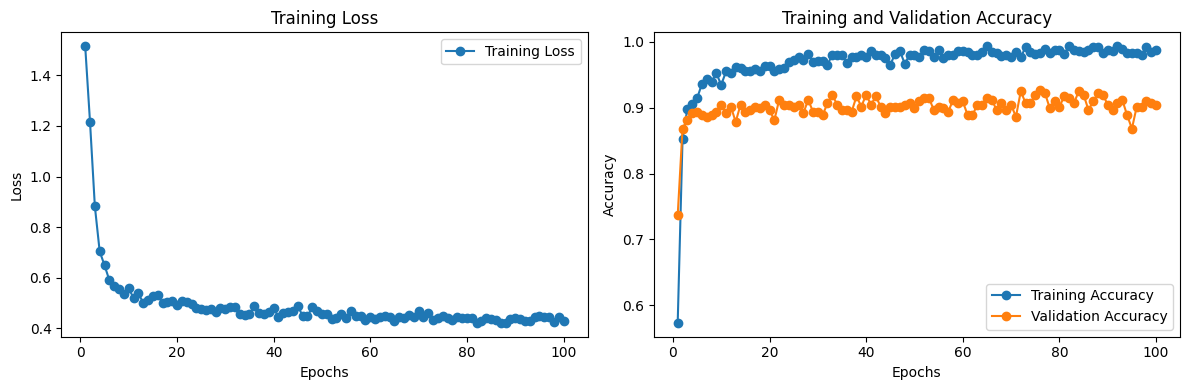

In [7]:
import os
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

@staticmethod
def collate_fn(batch):
    images, labels = tuple(zip(*batch))

    images = torch.stack(images, dim=0)
    labels = torch.as_tensor(labels)
    return images, labels

def main():
    train_loss_list = []  
    train_acc_list = []   
    val_acc_list = []     
    # 硬编码参数
    num_classes = 5
    epochs = 100
    batch_size = 16
    lr = 0.0001
    data_path = '/kaggle/working/pokeman/'
    weights = "/kaggle/input/deep-learning-bnuz-2023-fall-final-work/mobilevit_xxs.pt"
    freeze_layers = False
    device = 'cuda:0'

    device = torch.device(device if torch.cuda.is_available() else "cpu")

    if os.path.exists("./weights") is False:
        os.makedirs("./weights")

    tb_writer = SummaryWriter()
    img_size = 224

    batch_size = batch_size
    data = pd.read_excel('/kaggle/input/deep-learning-bnuz-2023-fall-final-work/images1.xlsx')
    data['class'] = 'a'
    for i in range(len(data)):
        a = data['path'][i].find('pokeman')+8
        b = data['path'][i].find("0000") -1 
        data['class'][i] = data['path'][i][a:b]
        data['number'][i] = data['path'][i][b:]
    print("class and image name is sucessfully added")
    class_set = set(data['class'])
    # 根据 "dataset" 列划分训练集和测试集
    train_data = data[data['dataset'] == 0]
    test_data = data[data['dataset'] == 1]
    # 定义数据转换
    data_transform = {
        "train": transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    # 定义数据集路径
    image_path_read = '/kaggle/input/deep-learning-bnuz-2023-fall-final-work/deeplearning/'  # 替换成实际的图片数据集路径
    # 定义数据集路径
    image_path = '/kaggle/working/pokeman/'  # 替换成实际的图片数据集路径
    # 创建训练集和测试集文件夹
    os.makedirs(os.path.join(image_path, "train"), exist_ok=True)
    for i in class_set:
        image_path_train = image_path + "train/"
        os.makedirs(os.path.join(image_path_train, i), exist_ok=True)
    os.makedirs(os.path.join(image_path, "test"), exist_ok=True)
    for i in class_set:
        image_path_test = image_path + "test/"
        os.makedirs(os.path.join(image_path_test, i), exist_ok=True)

    # 将训练集和测试集的图片复制到对应文件夹
    for index, row in train_data.iterrows():
        src_path = image_path_read + row['path']
        src_path = src_path.replace("\\", "/")
        
        dst_path = os.path.join(image_path_train+row['class'],row['number'])
        
        shutil.copy(src_path, dst_path)

    for index, row in test_data.iterrows():
        src_path = image_path_read + row['path']
        src_path = src_path.replace("\\", "/")
        dst_path = os.path.join(image_path_test+row['class'],row['number'])
        shutil.copy(src_path, dst_path)

    # 加载训练集和测试集的数据
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path+"/train"),
                                         transform=data_transform["train"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path+"/test"),
                                        transform=data_transform["val"])
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))
    train_num = len(train_dataset)

    # {'bulbasaur':0, 'charmander':1, 'mewtwo':2, 'pikachu':3, 'squirtle':4}
    class_list = train_dataset.class_to_idx
    print(class_list)
    cla_dict = dict((val, key) for key, val in class_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  
    print('Using {} dataloader workers every process'.format(nw))
    val_num = len(test_dataset)

    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=nw,
                                               collate_fn=collate_fn)

    val_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=nw,
                                             collate_fn=collate_fn)

    model = mobile_vit_xx_small(num_classes=num_classes).to(device)

    if weights != "":
        assert os.path.exists(weights), "weights file: '{}' not exist.".format(weights)
        weights_dict = torch.load(weights, map_location=device)
        weights_dict = weights_dict["model"] if "model" in weights_dict else weights_dict
        # 删除有关分类类别的权重
        for k in list(weights_dict.keys()):
            if "classifier" in k:
                del weights_dict[k]
        print(model.load_state_dict(weights_dict, strict=False))

    if freeze_layers:
        for name, para in model.named_parameters():
            # 除head外，其他权重全部冻结
            if "classifier" not in name:
                para.requires_grad_(False)
            else:
                print("training {}".format(name))

    pg = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(pg, lr=lr, weight_decay=1E-2)

    best_acc = 0.
    for epoch in range(epochs):
        # 训练集部分
        train_loss, train_acc = train_one_epoch(model=model,
                                                optimizer=optimizer,
                                                data_loader=train_loader,
                                                device=device,
                                                epoch=epoch)

        # 测试集部分
        val_loss, val_acc = evaluate(model=model,
                                     data_loader=val_loader,
                                     device=device,
                                     epoch=epoch)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        # 余下部分保持不变
        tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
        tb_writer.add_scalar(tags[0], train_loss, epoch)
        tb_writer.add_scalar(tags[1], train_acc, epoch)
        tb_writer.add_scalar(tags[2], val_loss, epoch)
        tb_writer.add_scalar(tags[3], val_acc, epoch)
        tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)


        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "./weights/best_model.pth")

        torch.save(model.state_dict(), "./weights/latest_model_mobileViT.pth")
    
     # 可视化训练过程
    plt.figure(figsize=(12, 4))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_loss_list, label='Training Loss', marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_acc_list, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig("result of MobileViT.png")
    plt.show()



if __name__ == '__main__':
    main()


In [8]:
!nvidia-smi


/bin/bash: nvidia-smi: command not found


In [9]:
!pip install pipreqs

!pipreqs /kaggle/working
!cat /kaggle/working/requirements.txt


class and image name is sucessfully added
using cpu device.
{'bulbasaur': 0, 'charmander': 1, 'mewtwo': 2, 'pikachu': 3, 'squirtle': 4}
Using 4 dataloader workers every process
using 780 images for training, 387 images for validation.
Using 4 dataloader workers every process
_IncompatibleKeys(missing_keys=['classifier.fc.weight', 'classifier.fc.bias'], unexpected_keys=[])
training classifier.fc.weight
training classifier.fc.bias
[valid epoch 99] loss: 0.593, acc: 0.842: 100%|██████████| 25/25 [00:07<00:00,  3.17it/s]


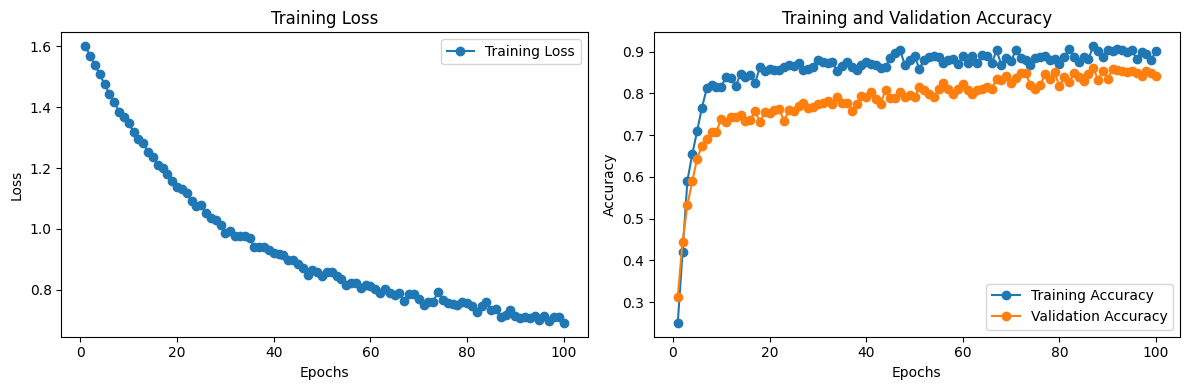

In [10]:
import os
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

@staticmethod
def collate_fn(batch):
    images, labels = tuple(zip(*batch))

    images = torch.stack(images, dim=0)
    labels = torch.as_tensor(labels)
    return images, labels

def main():
    train_loss_list = []  
    train_acc_list = []   
    val_acc_list = []     
    # 硬编码参数
    num_classes = 5
    epochs = 100
    batch_size = 16
    lr = 0.0001
    data_path = '/kaggle/working/pokeman/'
    weights = "/kaggle/input/deep-learning-bnuz-2023-fall-final-work/mobilevit_xxs.pt"
    freeze_layers = True
    device = 'cuda:0'

    device = torch.device(device if torch.cuda.is_available() else "cpu")

    if os.path.exists("./weights") is False:
        os.makedirs("./weights")

    tb_writer = SummaryWriter()
    img_size = 224

    batch_size = batch_size
    data = pd.read_excel('/kaggle/input/deep-learning-bnuz-2023-fall-final-work/images1.xlsx')
    data['class'] = 'a'
    for i in range(len(data)):
        a = data['path'][i].find('pokeman')+8
        b = data['path'][i].find("0000") -1 
        data['class'][i] = data['path'][i][a:b]
        data['number'][i] = data['path'][i][b:]
    print("class and image name is sucessfully added")
    class_set = set(data['class'])
    # 根据 "dataset" 列划分训练集和测试集
    train_data = data[data['dataset'] == 0]
    test_data = data[data['dataset'] == 1]
    # 定义数据转换
    data_transform = {
        "train": transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    # 定义数据集路径
    image_path_read = '/kaggle/input/deep-learning-bnuz-2023-fall-final-work/deeplearning/'  # 替换成实际的图片数据集路径
    # 定义数据集路径
    image_path = '/kaggle/working/pokeman/'  # 替换成实际的图片数据集路径
    # 创建训练集和测试集文件夹
    os.makedirs(os.path.join(image_path, "train"), exist_ok=True)
    for i in class_set:
        image_path_train = image_path + "train/"
        os.makedirs(os.path.join(image_path_train, i), exist_ok=True)
    os.makedirs(os.path.join(image_path, "test"), exist_ok=True)
    for i in class_set:
        image_path_test = image_path + "test/"
        os.makedirs(os.path.join(image_path_test, i), exist_ok=True)

    # 将训练集和测试集的图片复制到对应文件夹
    for index, row in train_data.iterrows():
        src_path = image_path_read + row['path']
        src_path = src_path.replace("\\", "/")
        
        dst_path = os.path.join(image_path_train+row['class'],row['number'])
        
        shutil.copy(src_path, dst_path)

    for index, row in test_data.iterrows():
        src_path = image_path_read + row['path']
        src_path = src_path.replace("\\", "/")
        dst_path = os.path.join(image_path_test+row['class'],row['number'])
        shutil.copy(src_path, dst_path)

    # 加载训练集和测试集的数据
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path+"/train"),
                                         transform=data_transform["train"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path+"/test"),
                                        transform=data_transform["val"])
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))
    train_num = len(train_dataset)

    # {'bulbasaur':0, 'charmander':1, 'mewtwo':2, 'pikachu':3, 'squirtle':4}
    class_list = train_dataset.class_to_idx
    print(class_list)
    cla_dict = dict((val, key) for key, val in class_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  
    print('Using {} dataloader workers every process'.format(nw))
    val_num = len(test_dataset)

    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=nw,
                                               collate_fn=collate_fn)

    val_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=nw,
                                             collate_fn=collate_fn)

    model = mobile_vit_xx_small(num_classes=num_classes).to(device)

    if weights != "":
        assert os.path.exists(weights), "weights file: '{}' not exist.".format(weights)
        weights_dict = torch.load(weights, map_location=device)
        weights_dict = weights_dict["model"] if "model" in weights_dict else weights_dict
        # 删除有关分类类别的权重
        for k in list(weights_dict.keys()):
            if "classifier" in k:
                del weights_dict[k]
        print(model.load_state_dict(weights_dict, strict=False))

    if freeze_layers:
        for name, para in model.named_parameters():
            # 除head外，其他权重全部冻结
            if "classifier" not in name:
                para.requires_grad_(False)
            else:
                print("training {}".format(name))

    pg = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(pg, lr=lr, weight_decay=1E-2)

    best_acc = 0.
    for epoch in range(epochs):
        # 训练集部分
        train_loss, train_acc = train_one_epoch(model=model,
                                                optimizer=optimizer,
                                                data_loader=train_loader,
                                                device=device,
                                                epoch=epoch)

        # 测试集部分
        val_loss, val_acc = evaluate(model=model,
                                     data_loader=val_loader,
                                     device=device,
                                     epoch=epoch)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        # 余下部分保持不变
        tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
        tb_writer.add_scalar(tags[0], train_loss, epoch)
        tb_writer.add_scalar(tags[1], train_acc, epoch)
        tb_writer.add_scalar(tags[2], val_loss, epoch)
        tb_writer.add_scalar(tags[3], val_acc, epoch)
        tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)


        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "./weights/best_model.pth")

        torch.save(model.state_dict(), "./weights/latest_model_mobileViT.pth")
    
     # 可视化训练过程
    plt.figure(figsize=(12, 4))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_loss_list, label='Training Loss', marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_acc_list, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig("result of MobileViT.png")
    plt.show()



if __name__ == '__main__':
    main()
